# Sobre o projeto

Conforme a descrição e README deste projeto, o objetivo é realizar uma exploração e modelagem de um modelo de Machine Learning conforme o material visto durante as aulas.

Escolhemos construir um **modelo para prever a geração de energia de usinas térmicas** e outro para **detecção de anomalias** com base em suas condições de operação, como temperatura e pressão.

## Sobre os dados

Os dados foram obtidos via [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/power-plant-data/data) e estão na pasta `data`.

Eles foram divididos entre treino e teste pelo próprio autor do dataset.

## Importações

Centralização das importações que serão utilizadas ao longo do arquivo em diversas etapas

In [2]:
from os.path import join

# Análise
import pandas as pd
import numpy as np

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Machine Learning - Modelos e métricas
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Importanto os dados

In [3]:
energy_train_data = pd.read_csv(join('data','Training_set_ccpp.csv'))
energy_test_data = pd.read_csv(join('data', 'Testing_set_ccpp.csv'))
energy_data = pd.concat([energy_train_data, energy_test_data], keys=['train', 'test'])

energy_data

AT     EV       AP     RH      PE
train 0     29.95  73.42  1011.44  66.32  432.81
      1      5.76  40.07  1013.22  62.99  494.67
      2     29.44  64.33  1011.40  61.78  442.32
      3     32.83  74.33  1011.44  50.42  427.36
      4     16.86  39.63  1004.47  83.50  466.68
...           ...    ...      ...    ...     ...
test  3153  22.12  57.19  1007.56  76.50     NaN
      3154   9.59  38.56  1017.01  60.10     NaN
      3155  31.38  71.32  1009.17  60.42     NaN
      3156  12.38  45.51  1016.15  81.37     NaN
      3157  22.35  65.61  1016.27  73.93     NaN

[9568 rows x 5 columns]

# Desenvolvimento

## EDA (Exploratory Data Analysis) dos dados

Aqui os dados serão analisados de forma geral, ajudando a compreender melhor seus padrões e comportamento, além de quais tratamentos e/ou criações de novas colunas podem aparecer na etapa de pré-processamento.

### Sobre

Como implícito no nome dos dois datasets, eles foram divididos em dataset de treino (energy_train_dataset) e dataset de test(energy_test_dataset). Ao analisarmos ambos os datasets observamos que possuímos as seguintes colunas a seguir:

Consultando o dicionário de dados chegamos temos a explicação do que se trata as inicias de cada variável bem como a unidade em que estão sendo medidas, segundo a tabela a seguir:

| Coluna    | Unidade   | Descrição |
|--------   |---------  |-----------|
| `AT`      | *°C*      | Temperatura ambiente
| `EV`      | *Hg*      | Vácuo de Exaustão
| `AP`      | *mbar*    | Pressão ambiente
| `RH`      | *%*       | Humidade Relativa
| `PE`      | *MW*      | Geração de energia elétrica

Conforme explicitamente recomendado pela fonte de dados iremos utilizar apenas o dataset de treino (train) para realizar o treino do modelo. Logo todas as análises e tratamento a seguir serão realizadas apenas neste dataset.

### Informações gerais do dataset

In [3]:
print(f'''Train Shape: {energy_train_data.shape}
Test Shape: {energy_test_data.shape}''')

Train Shape: (6410, 5)
Test Shape: (3158, 4)


A tabela de teste não possui a coluna **PE**, já que é nosso target.\
Todos os dados são do tipo float - mas contém medidas/faixas diferentes

In [4]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9568 entries, ('train', np.int64(0)) to ('test', np.int64(3157))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   EV      9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      6410 non-null   float64
dtypes: float64(5)
memory usage: 710.1+ KB


Também não temos valores nulos no dataset.

In [5]:
energy_train_data.isna().sum()

AT    0
EV    0
AP    0
RH    0
PE    0
dtype: int64

Temos uma pequena quantidade de dados duplicados tanto no conjunto de treino quanto no de teste. Logo iremos removê-los para que não influenciem no nosso modelo.

In [6]:
len(energy_data[energy_data.duplicated()])

18

In [7]:
len(energy_data.loc['train'][energy_data.loc['train'].duplicated()])

14

In [8]:
len(energy_data.loc['test'][energy_data.loc['test'].duplicated()])

4

Além disso, não é falado exatamente **como** foi feita a divisão entre treino e teste, por conta disso, decidimos verificar se todos os conjuntos do dataset de teste foram retirados do dataset de treino, verificando se todos os dados entre eles são duplicados

In [9]:
len(energy_data.drop(columns='PE')[energy_data.drop(columns='PE').duplicated()])

41

Apenas 41 valores são duplicados, isso significa que os datasets foram separados corretamente e podemos trabalhar com eles de forma separada.

In [10]:
energy_data = energy_data.drop_duplicates()
energy_data

AT     EV       AP     RH      PE
train 0     29.95  73.42  1011.44  66.32  432.81
      1      5.76  40.07  1013.22  62.99  494.67
      2     29.44  64.33  1011.40  61.78  442.32
      3     32.83  74.33  1011.44  50.42  427.36
      4     16.86  39.63  1004.47  83.50  466.68
...           ...    ...      ...    ...     ...
test  3153  22.12  57.19  1007.56  76.50     NaN
      3154   9.59  38.56  1017.01  60.10     NaN
      3155  31.38  71.32  1009.17  60.42     NaN
      3156  12.38  45.51  1016.15  81.37     NaN
      3157  22.35  65.61  1016.27  73.93     NaN

[9550 rows x 5 columns]

In [11]:
len(energy_data[energy_data.duplicated()])

0

Verificando o comportamento dos dados abaixo, percebemos que precisamos tomar cuidado com alguns pontos:

- A diferença entre cada coluna é alta, principalmente quando olhamos para `AP` e `PE` - uma normalização ou padronização dos dados é necessária
- Não há valores '0' nos mínimos - algumas bases gostam de incluir o valor 0 para representar algo vazio/nulo
- O desvio padrão não é tão alto e a média está próxima dos valores encontrados nos quartis, mesmo assim, é interessante ainda checar por algum outlier

In [12]:
display(energy_data.loc['train'].describe())
display(energy_data.loc['test'].describe())

,AT,EV,AP,RH,PE
count,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000
mean,19.655775,54.289472,1013.218404,73.318247,454.350688
std,7.428144,12.675436,5.933810,14.684819,17.040970
min,1.810000,25.360000,992.890000,26.300000,420.260000
25%,13.580000,41.760000,1009.060000,63.340000,439.830000
50%,20.420000,52.065000,1012.945000,74.955000,451.440000
75%,25.720000,66.517500,1017.220000,84.902500,468.240000
max,35.560000,81.560000,1033.300000,100.160000,495.760000


,AT,EV,AP,RH,PE
count,3154.000000,3154.000000,3154.000000,3154.000000,0.0
mean,19.650682,54.314892,1013.315425,73.284902,NaN
std,7.489298,12.748654,5.952444,14.449347,NaN
min,2.340000,25.360000,993.110000,25.560000,NaN
25%,13.412500,41.670000,1009.170000,63.247500,NaN
50%,20.250000,52.300000,1012.915000,74.975000,NaN
75%,25.710000,66.540000,1017.240000,84.545000,NaN
max,37.110000,79.740000,1033.250000,100.150000,NaN


#### Análises gráficas

Verificando a distribuição das variáveis

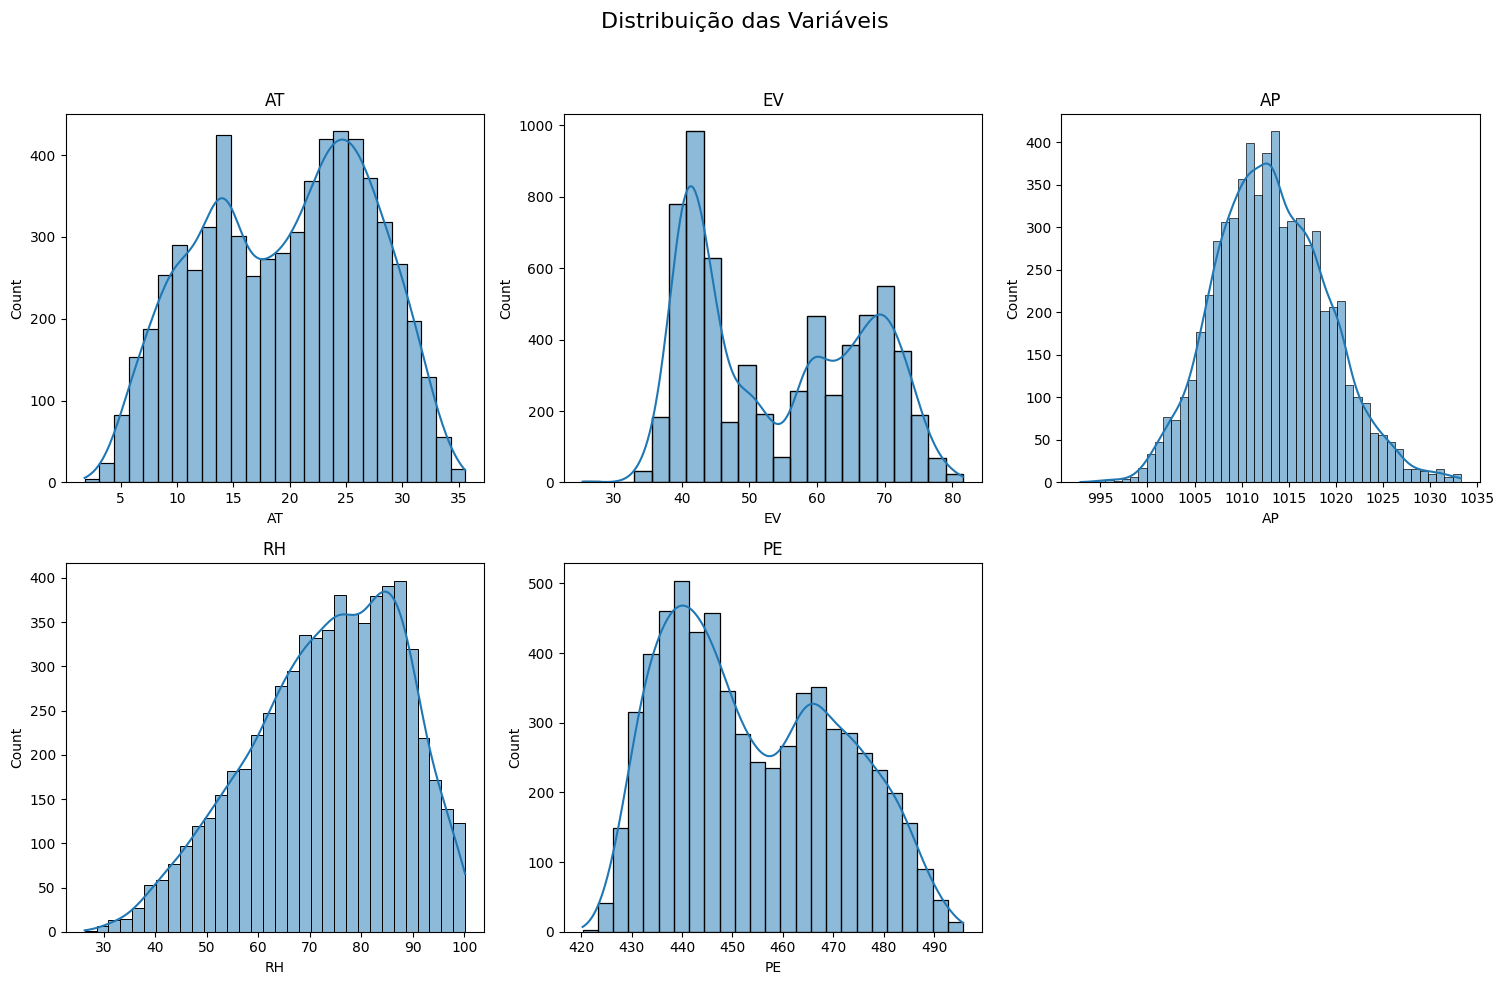

In [13]:
cols = 3
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
fig.suptitle("Distribuição das Variáveis", fontsize=16)

for i, col in enumerate(energy_data.loc["train"].columns):
    ax = axes[i // cols, i % cols]
    sns.histplot(energy_data.loc["train", col], kde=True, ax=ax)
    ax.set_title(col)
    
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Verificando se há outliers com boxplots

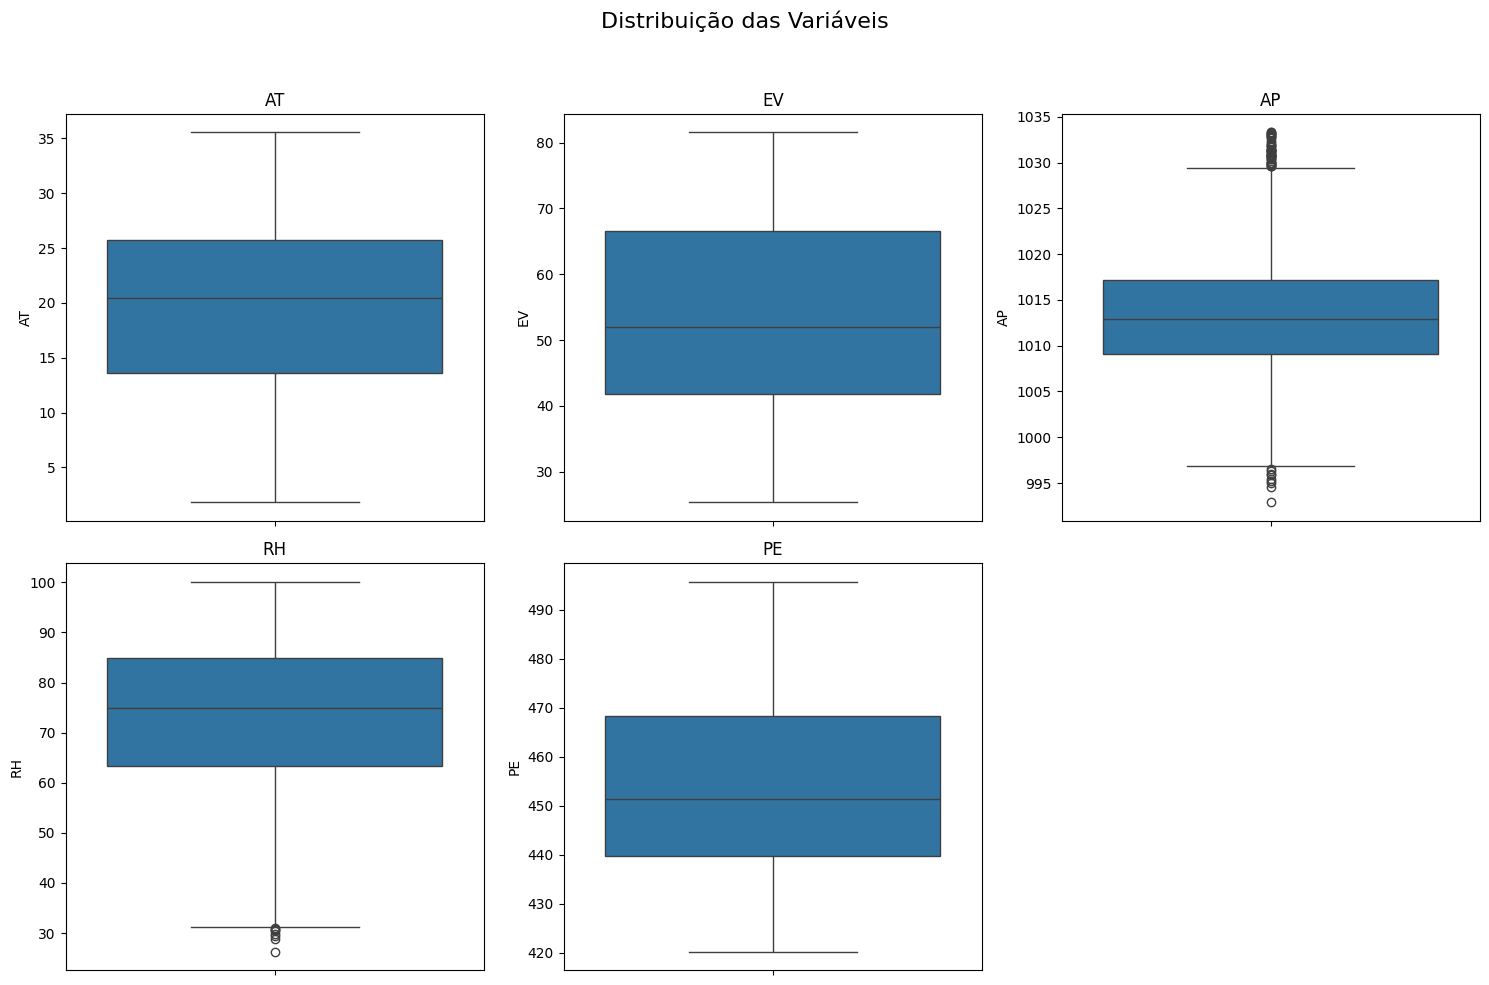

In [14]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
fig.suptitle("Distribuição das Variáveis", fontsize=16)

for i, col in enumerate(energy_data.loc["train"].columns):
    ax = axes[i // cols, i % cols]
    sns.boxplot(energy_data.loc["train", col], ax=ax)
    ax.set_title(col)
    
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Apenas AP e RH foram marcados com outliers. Para o nosso **modelo supervisionado** a remoção de outliers é algo que ajudaria o modelo, mas para o **não supervisionado**, poderia acabar prejudicando, já que o objetivo seria identificar anomalias.

---

Como nossos dados são contínuos, a correlação mais apropriada é a de *Pearson*

Avaliando o heatmap abaixo, percebemos que há uma fortíssima correlação negativa entre PE e AT (-0.948) e também entre PE e EV (-0.869), indicando que quanto menor a temperatura ambiente e quanto mentor o vácuo de exaustão maior será a geração de energia. Também vemos que há uma baixa correlação com RH (0.394)

Mediante estas análises, podemos levar em consideração que seguir com todas as variáveis, exceto **RH**, podem nos ajudar no treinamento do nosso modelo.

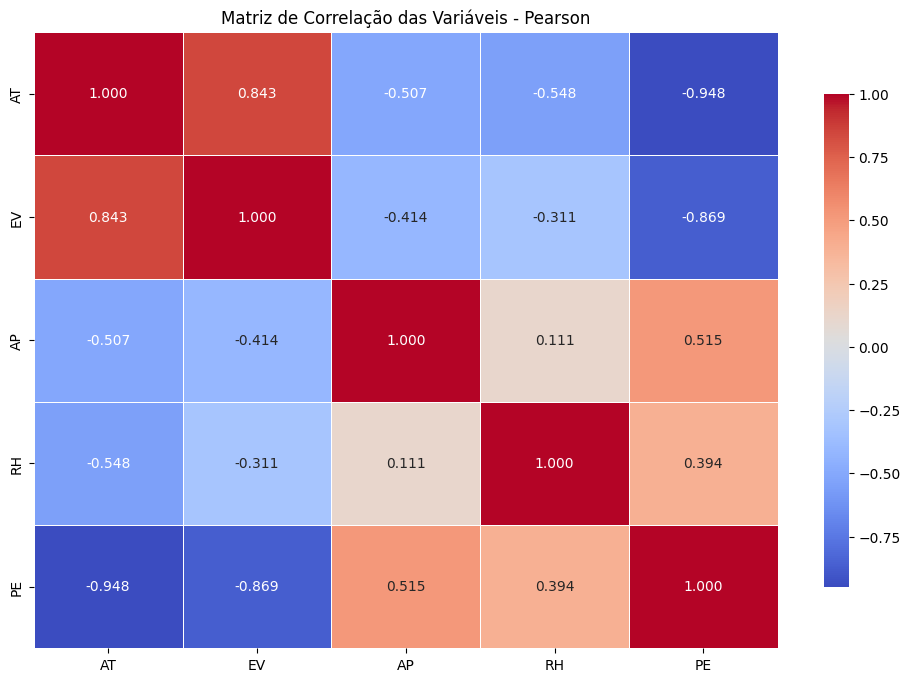

In [15]:
correlation_matrix = energy_data.loc['train'].corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Matriz de Correlação das Variáveis - Pearson")
plt.show()

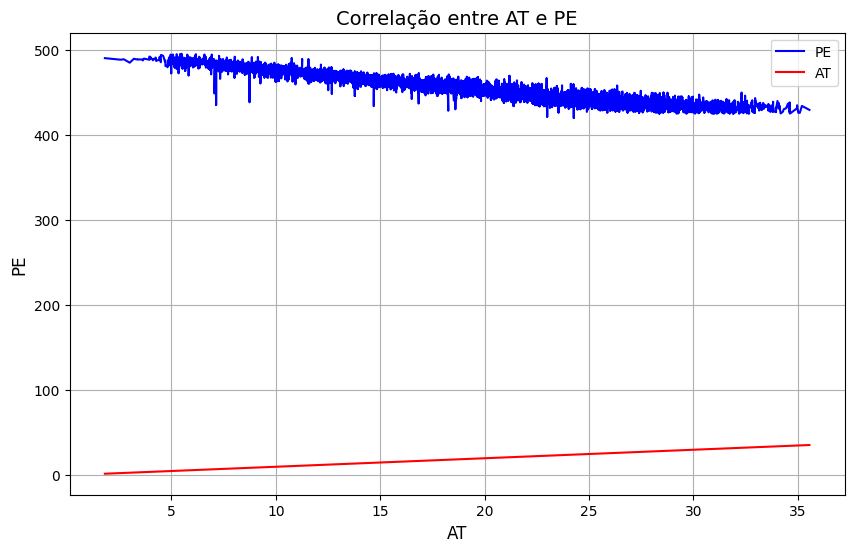

In [49]:
plt.figure(figsize=(10, 6))

train_sorted = energy_data.loc['train'].sort_values(by='AT')

plt.plot(train_sorted['AT'], train_sorted['PE'], label='PE', color='blue')
plt.plot(train_sorted['AT'], train_sorted['AT'], label='AT', color='red')

plt.title('Correlação entre AT e PE', fontsize=14)
plt.xlabel('AT', fontsize=12)
plt.ylabel('PE', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

*Obs.: Acima, apenas verificamos a correlação e outros gráficos no conjunto de treino, justamente para evitar o conceito de 'vazamento de dados' - neste contexto, seria como criar um modelo que fosse servir perfeitamente para nosso cenário de testes.*

### Remoção de outliers e escolha de features

Como já falado, para nosso modelo não supervisionado, acaba não fazendo sentido excluir variáveis ou outliers, portanto, faremos uma **cópia** do dataset atual (que já removeu seus dados duplicados) para, futuramente, ser utilizada para o outro modelo.

In [16]:
un_energy_data = energy_data.copy()
print(un_energy_data.shape)
print(energy_data.shape)

(9550, 5)
(9550, 5)


Conforme visto nos gráficos de boxplot, apenas `RH` e `AP` possuem outliers e, como não vamos utilizar `RH`, podemos aplicar a remoção apenas em `AP`.

In [17]:
features_to_keep=['AT', 'EV', 'AP', 'PE']

energy_data = energy_data[features_to_keep]
energy_data

AT     EV       AP      PE
train 0     29.95  73.42  1011.44  432.81
      1      5.76  40.07  1013.22  494.67
      2     29.44  64.33  1011.40  442.32
      3     32.83  74.33  1011.44  427.36
      4     16.86  39.63  1004.47  466.68
...           ...    ...      ...     ...
test  3153  22.12  57.19  1007.56     NaN
      3154   9.59  38.56  1017.01     NaN
      3155  31.38  71.32  1009.17     NaN
      3156  12.38  45.51  1016.15     NaN
      3157  22.35  65.61  1016.27     NaN

[9550 rows x 4 columns]

In [18]:
train = energy_data.loc['train']

print(f"Shape com outliers: {energy_data.loc['train'].shape}")

Q1 = train['AP'].quantile(0.25)
Q3 = train['AP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train = train[(train['AP'] >= lower_bound) & (train['AP'] <= upper_bound)]
    
print(f"Shape sem outliers: {train.shape}")
train

Shape com outliers: (6396, 4)
Shape sem outliers: (6341, 4)


,AT,EV,AP,PE
0,29.95,73.42,1011.44,432.81
1,5.76,40.07,1013.22,494.67
2,29.44,64.33,1011.40,442.32
3,32.83,74.33,1011.44,427.36
4,16.86,39.63,1004.47,466.68
...,...,...,...,...
6405,23.39,61.87,1010.35,444.03
6406,11.63,40.55,1022.89,474.67
6407,27.79,69.23,1012.86,435.06
6408,12.26,41.50,1014.87,471.13


In [19]:
test = energy_data.loc['test'].drop(columns='PE')
test

,AT,EV,AP
0,19.64,48.06,1014.81
1,28.26,69.23,1013.01
2,27.98,67.17,1007.32
3,28.64,69.23,1013.11
4,9.34,38.08,1019.56
...,...,...,...
3153,22.12,57.19,1007.56
3154,9.59,38.56,1017.01
3155,31.38,71.32,1009.17
3156,12.38,45.51,1016.15


Mais uma vez, para evitar vazamento de dados, vamos aplicar separadamente a normalização. Optamos por utilizar o MinMaxScaler, já que os dados não estão em distribuição normal - conforme visto nos histogramas.

In [20]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.83377778, 0.85516014, 0.44775661, 0.16622517],
       [0.11703704, 0.26174377, 0.50245851, 0.98556291],
       [0.81866667, 0.69341637, 0.44652735, 0.29218543],
       ...,
       [0.76977778, 0.78060498, 0.49139521, 0.19602649],
       [0.30962963, 0.28718861, 0.55316533, 0.67377483],
       [0.29451852, 0.2702847 , 0.65212047, 0.69099338]])

# Treinando e testando o modelo - Modelo Supervisionado

### Separação dos dados

In [21]:
X = train.drop(columns='PE')
y = train['PE']

Como já temos datasets de **treino** e **teste**, ao dividirmos os dados de treino com `train_test_split`, é como se estivéssemos criando um conjunto de **validação**

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Treinando modelos

Segundo a descrição do projeto, para modelos supervisionados, podemos apenas utilizar SVM ou modelos de Ensembles.

In [ ]:
def train_and_validate_model(
    model, X_train, X_val, y_train, y_val, hyperparameters=None
):
    """
    Função para treinar e validar um modelo de regressão.

    Parâmetros:
    - model: Instância do modelo de regressão a ser treinado
    - X_train: Dados de treino (features)
    - X_val: Dados de validação (features)
    - y_train: Labels de treino (target)
    - y_val: Labels de validação (target)
    - hyperparameters: Dicionário com os hiperparâmetros para o modelo

    Retorna:
    - score: Pontuação do modelo (erro quadrático médio)
    """

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_val)

    if hyperparameters:
        print("\tTreinando hiperparâmetros do modelo...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=hyperparameters,
            cv=5,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        grid_search.fit(X_train_scaled, y_train)
        best_params = grid_search.best_params_
        print(f"\tMelhores parâmetros: {best_params}")
        model.set_params(**best_params)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    scores = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}
    
    if hyperparameters:
        return scores, best_params

    return scores

In [ ]:
models = {
    'SVR': SVR(), # Support Vector Regressor
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBoost': XGBRegressor()
}

all_scores = {}
for model_name, model in models.items():
    print(f'Treinando {model_name}...')
    scores = train_and_validate_model(model, X_train, X_val, y_train, y_val)
    all_scores[model_name] = scores

print("\nScores dos Modelos:")
all_scores

Treinando SVR...
Treinando RandomForestRegressor...
Treinando GradientBoostingRegressor...
Treinando AdaBoostRegressor...
Treinando XGBoost...

Scores dos Modelos:


{'SVR': {'MSE': np.float64(17.282115368177585),
  'MAE': np.float64(3.220566255440585),
  'RMSE': np.float64(4.157176369626093),
  'R2': 0.9373537824828972},
 'RandomForestRegressor': {'MSE': np.float64(12.742664166611537),
  'MAE': np.float64(2.638795508274237),
  'RMSE': np.float64(3.5696868443340426),
  'R2': 0.9538089120386936},
 'GradientBoostingRegressor': {'MSE': np.float64(14.36516751720134),
  'MAE': np.float64(2.971845397684129),
  'RMSE': np.float64(3.790140830787339),
  'R2': 0.9479274735887201},
 'AdaBoostRegressor': {'MSE': np.float64(28.976593349856614),
  'MAE': np.float64(4.248977760610076),
  'RMSE': np.float64(5.3829911155283),
  'R2': 0.8949622814552954},
 'XGBoost': {'MSE': np.float64(10.813952922461926),
  'MAE': np.float64(2.4181111422779993),
  'RMSE': np.float64(3.2884575293687353),
  'R2': 0.9608003283991676}}

Sobre os scores utilizados:

- MSE (Mean Squared Error): Quanto menor, melhor. Representa o erro médio ao quadrado.
- MAE (Mean Absolute Error): Quanto menor, melhor. Representa o erro médio absoluto.
- RMSE (Root Mean Squared Error): Quanto menor, melhor. Representa a raiz quadrada do erro quadrático médio.
- R² (Coeficiente de Determinação): Quanto maior, melhor. Mede a proporção da variância explicada pelo modelo.

Sendo assim, dos modelos acima, o melhor acabou sendo o `XGBoost`, pois tem as menores **MSE, MAE e RMSE**, ao mesmo tempo que possui o maior **R²**.

Já os outros modelos, que não performaram tão bem, seria interessante tentar aplicar alguns hiperparâmetros, para ver se a performance consegue ficar ainda melhor que o XGBoost.

In [25]:
param_grids = {
    'SVR': {
        'C': [1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'AdaBoostRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5]
    }
}

In [26]:
models = {
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRegressor': XGBRegressor()
}

tuned_all_scores = {}
best_params = {}
print('--- Treinando modelos com hiperparâmetros ---')
for model_name, model in models.items():
    print(f'Treinando {model_name}...')
    scores, params = train_and_validate_model(model, X_train, X_val, y_train, y_val, hyperparameters=param_grids[model_name])
    tuned_all_scores[model_name] = scores
    best_params[model_name] = params

print("\nScores dos Modelos:")
tuned_all_scores

--- Treinando modelos com hiperparâmetros ---
Treinando SVR...
	Treinando hiperparâmetros do modelo...
	Melhores parâmetros: {'C': 100, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Treinando RandomForestRegressor...
	Treinando hiperparâmetros do modelo...
	Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Treinando GradientBoostingRegressor...
	Treinando hiperparâmetros do modelo...
	Melhores parâmetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Treinando AdaBoostRegressor...
	Treinando hiperparâmetros do modelo...
	Melhores parâmetros: {'learning_rate': 0.01, 'n_estimators': 100}
Treinando XGBRegressor...
	Treinando hiperparâmetros do modelo...
	Melhores parâmetros: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Scores dos Modelos:


{'SVR': {'MSE': np.float64(16.70970245982774),
  'MAE': np.float64(3.1245847354071143),
  'RMSE': np.float64(4.087750293233154),
  'R2': 0.9394287312262735},
 'RandomForestRegressor': {'MSE': np.float64(12.449489890593371),
  'MAE': np.float64(2.6426946022364257),
  'RMSE': np.float64(3.5283834670558942),
  'R2': 0.9548716441796716},
 'GradientBoostingRegressor': {'MSE': np.float64(10.979161825458997),
  'MAE': np.float64(2.487128649493443),
  'RMSE': np.float64(3.3134818281467906),
  'R2': 0.9602014599937424},
 'AdaBoostRegressor': {'MSE': np.float64(23.51640449229246),
  'MAE': np.float64(3.8064094859428583),
  'RMSE': np.float64(4.849371556427952),
  'R2': 0.914755007725673},
 'XGBRegressor': {'MSE': np.float64(9.542753207938897),
  'MAE': np.float64(2.2970720372602074),
  'RMSE': np.float64(3.0891347021356803),
  'R2': 0.9654083206574723}}

O melhor modelo continua sendo o mesmo, mas houve destaque para o `GradientBoostingRegressor`. Ele performou melhor que todos os outros modelos nas outras categorias, exceto quando comparado ao `XGBRegressor`.

Dito isso, uma ideia que tivemos para tentar melhorar *ainda mais* o modelo final, optamos por criar um **Emsemble combinando os dois melhores**, criando um modelo ainda mais completo.

In [27]:
print("XGBRegressor e GradientBoostingRegressor antes de tunar os hiperparâmetros:")
print(f"\tXGBoost: {all_scores['XGBoost']}")
print(f"\tGradientBoostingRegressor: {all_scores['GradientBoostingRegressor']}")

print("\nXGBRegressor e GradientBoostingRegressor DEPOIS de tunar os hiperparâmetros:")
print(f"\tXGBoost: {tuned_all_scores['XGBRegressor']}")
print(f"\tGradientBoostingRegressor: {tuned_all_scores['GradientBoostingRegressor']}")

XGBRegressor e GradientBoostingRegressor antes de tunar os hiperparâmetros:
	XGBoost: {'MSE': np.float64(10.813952922461926), 'MAE': np.float64(2.4181111422779993), 'RMSE': np.float64(3.2884575293687353), 'R2': 0.9608003283991676}
	GradientBoostingRegressor: {'MSE': np.float64(14.36516751720134), 'MAE': np.float64(2.971845397684129), 'RMSE': np.float64(3.790140830787339), 'R2': 0.9479274735887201}

XGBRegressor e GradientBoostingRegressor DEPOIS de tunar os hiperparâmetros:
	XGBoost: {'MSE': np.float64(9.542753207938897), 'MAE': np.float64(2.2970720372602074), 'RMSE': np.float64(3.0891347021356803), 'R2': 0.9654083206574723}
	GradientBoostingRegressor: {'MSE': np.float64(10.979161825458997), 'MAE': np.float64(2.487128649493443), 'RMSE': np.float64(3.3134818281467906), 'R2': 0.9602014599937424}


Ambos ficaram melhores após a tunagem, então usaremos eles para criar o ensemble.

Utilizamos `weights` (pesos), fornecendo um valor maior para o XGB do que para o GB, já que ele está performando melhor.

In [34]:
xgb = XGBRegressor(**best_params['XGBRegressor'])
gb = GradientBoostingRegressor(**best_params['GradientBoostingRegressor'])

ensemble_model = VotingRegressor(estimators=[('xgb', xgb), ('gb', gb)], weights=[2, 1])

print('Treinando VotingRegressor...')
scores = train_and_validate_model(ensemble_model, X_train, X_val, y_train, y_val)

print("Scores do Voting:")
scores

Treinando VotingRegressor...
Scores do Voting:


{'MSE': np.float64(9.465649976580275),
 'MAE': np.float64(2.316138003067807),
 'RMSE': np.float64(3.0766296456642737),
 'R2': 0.9656878133989603}

Ficou um pouco melhor do que o XGBRegressor. Vamos tentar colocar o 3° melhor modelo no meio também, para verificar se ficaria ainda melhor:

In [35]:
rf = RandomForestRegressor(**best_params['RandomForestRegressor'])

ensemble_model_rf = VotingRegressor(estimators=[('xgb', xgb), ('gb', gb), ('rf', rf)], weights=[3, 2, 1])

print('Treinando VotingRegressor...')
scores = train_and_validate_model(ensemble_model, X_train, X_val, y_train, y_val)

print("Scores do Voting:")
scores

Treinando VotingRegressor...
Scores do Voting:


{'MSE': np.float64(9.378520080306663),
 'MAE': np.float64(2.3030805166624138),
 'RMSE': np.float64(3.0624369512377987),
 'R2': 0.9660036519591084}

Não teve muita mudança com o Voting incluindo o Random Forest, ficando um pouco abaixo. Dessa forma, decidimos seguir com o voting anterior.

Além disso, decidimos testar o SVR (que não performou tão bem) junto com esses outros modelos, pois o SVR acaba sendo mais 'diferente' que os outros, logo, talvez um stacking que aproveite ele seja mais eficiente no final.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

xgb = XGBRegressor(**best_params['XGBRegressor'])
gb = GradientBoostingRegressor(**best_params['GradientBoostingRegressor'])
rf = RandomForestRegressor(**best_params['RandomForestRegressor'])
svr = SVR(**best_params['SVR'])

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=[('xgb', xgb), ('gb', gb), ('rf', rf), ('svr', svr)], final_estimator=meta_model)

print('Treinando StackingRegressor...')
scores = train_and_validate_model(stacking_model, X_train, X_val, y_train, y_val)
print("Scores do Stacking:")
print(scores)


Treinando StackingRegressor...
Scores do Stacking:
{'MSE': np.float64(9.300021223794863), 'MAE': np.float64(2.2852416729334526), 'RMSE': np.float64(3.049593616171647), 'R2': 0.9662882037246253}


O Stacking ficou um pouco melhor que o melhor modelo de Voting.

Sendo assim, no final, os melhores modelos foram, respectivamente:
- Stacking com XGB + GB + Random Forest + SVR, utilizando LinearRegression como estimador
- Voting com XGB + GB, colocando um maior peso no XGB
- Modelo XGB com seus melhores hiperparâmetros

### Rodando no conjunto de teste

In [38]:
test.sample(3)

,AT,EV,AP
1712,15.43,39.64,1008.58
2459,24.30,69.23,1013.17
1340,24.22,61.86,1013.39


In [40]:
# Necessário fit_transform ao invés de transform, já que as colunas são diferentes
test_scaled = scaler.fit_transform(test)

print('Prevendo PE com stacking_model...')
y_pred = stacking_model.predict(test_scaled)

Prevendo PE com stacking_model...


In [52]:
test['PE'] = np.round(y_pred, 2)
test

,AT,EV,AP,PE
0,19.64,48.06,1014.81,454.91
1,28.26,69.23,1013.01,436.14
2,27.98,67.17,1007.32,437.62
3,28.64,69.23,1013.11,436.45
4,9.34,38.08,1019.56,480.67
...,...,...,...,...
3153,22.12,57.19,1007.56,445.36
3154,9.59,38.56,1017.01,480.96
3155,31.38,71.32,1009.17,433.76
3156,12.38,45.51,1016.15,468.01


In [50]:
train

,AT,EV,AP,PE
0,29.95,73.42,1011.44,432.81
1,5.76,40.07,1013.22,494.67
2,29.44,64.33,1011.40,442.32
3,32.83,74.33,1011.44,427.36
4,16.86,39.63,1004.47,466.68
...,...,...,...,...
6405,23.39,61.87,1010.35,444.03
6406,11.63,40.55,1022.89,474.67
6407,27.79,69.23,1012.86,435.06
6408,12.26,41.50,1014.87,471.13


O nosso conjunto de dados não permite criar um score com os valores finais previstos de PE e os valores reais, pois ele exclui a coluna PE do dataset de testes. Mesmo assim, podemos verificar se o PE está mantendo seu padrão ao analisar, novamente, as correlações anteriores e compará-lo com o que temos no conjunto de treino.

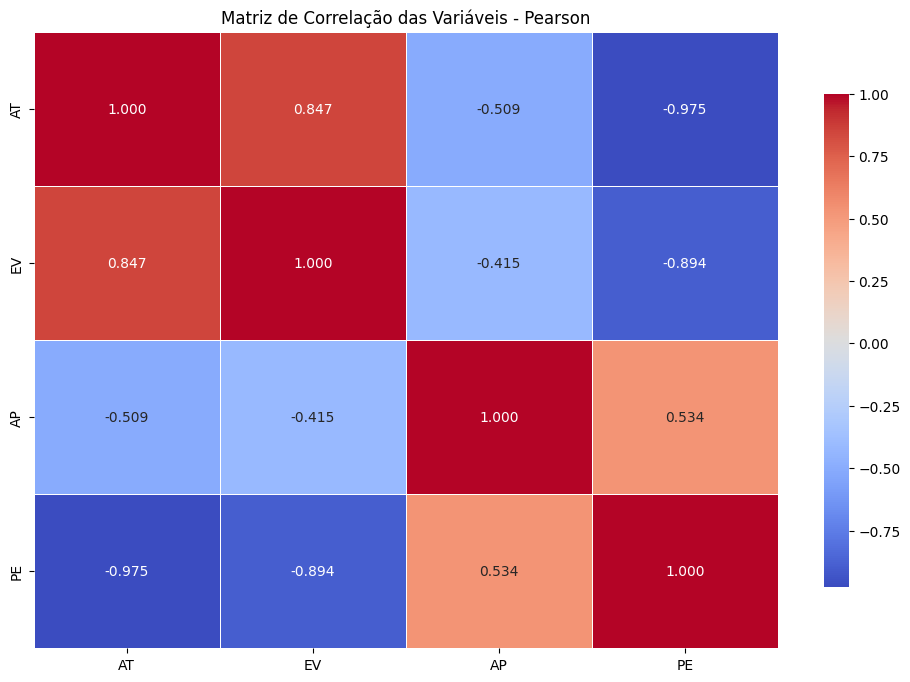

In [66]:
test_correlation_matrix = test.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(test_correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Matriz de Correlação das Variáveis - Pearson")
plt.show()

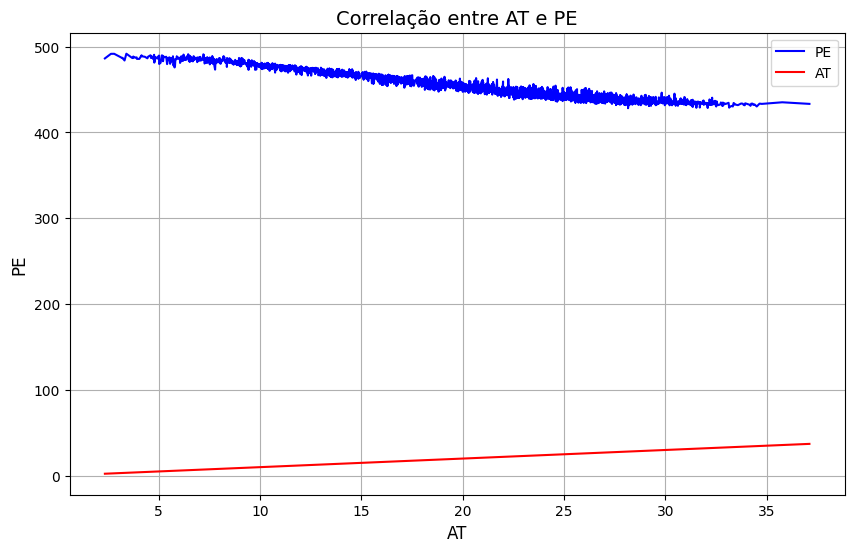

In [48]:
plt.figure(figsize=(10, 6))

test_sorted = test.sort_values(by='AT')

plt.plot(test_sorted['AT'], test_sorted['PE'], label='PE', color='blue')
plt.plot(test_sorted['AT'], test_sorted['AT'], label='AT', color='red')

plt.title('Correlação entre AT e PE', fontsize=14)
plt.xlabel('AT', fontsize=12)
plt.ylabel('PE', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

Os resultados são bem parecidos. Além disso, lá no começo do notebook vimos que os datasets de treino e teste possuem valores repetidos quando retiramos a coluna 'PE' e, mesmo assim, ao tentar ver se há algum resultado idêntico/duplicado com nossos novos valores de PE, nenhum se repete - ou seja, não está dando overfitting

In [68]:
concat_test = pd.concat([train, test], keys=['train', 'test'])
concat_test[concat_test.duplicated()]

,,AT,EV,AP,PE


Esse foi nosso **modelo supervisionado**! Ele pode nos ajudar a prever a geração de energia de usinas térmicas, ajudando essas empresas a terem uma noção sobre possíveis gastos com a energia, ou até mesmo prever danos no meio ambiente ao identificar um alto consumo.

> O modelo não-supervisionado foi separado em outro arquivo, para facilitar a visualização

# Modelo não supervisionado

Para o modelo não supervisionado, pretendemos utilizar apenas os **dados de treino**, já que queremos justamente analisar **irregularidades**, então queremos fazer esta análise nos dados completos.

Por conta disso, aqui não queremos considerar o dataset que já foi tratado e passou pelas etapas de remoção de outliers e escolha de features. Por isso, vamos buscar o dataset original. A única etapa que iremos manter é a da **normalização dos dados**, que é importante para algoritmos como o DBSCAN - que vamos utilizar.

Além disso, já analisamos os dados anteriormente, então sabemos que não há valores nulos/ausentes nos dados, então podemos ignorar toda essa verificação.

In [46]:
energy_train_data = pd.read_csv(join('data','Training_set_ccpp.csv')).drop_duplicates()
energy_train_data

,AT,EV,AP,RH,PE
0,29.95,73.42,1011.44,66.32,432.81
1,5.76,40.07,1013.22,62.99,494.67
2,29.44,64.33,1011.40,61.78,442.32
3,32.83,74.33,1011.44,50.42,427.36
4,16.86,39.63,1004.47,83.50,466.68
...,...,...,...,...,...
6405,23.39,61.87,1010.35,48.91,444.03
6406,11.63,40.55,1022.89,87.12,474.67
6407,27.79,69.23,1012.86,45.71,435.06
6408,12.26,41.50,1014.87,89.41,471.13


In [47]:
scaler = MinMaxScaler()
scaled_energy_train_data = scaler.fit_transform(energy_train_data)
scaled_energy_train_data

array([[0.83377778, 0.85516014, 0.45904479, 0.54183591, 0.16622517],
       [0.11703704, 0.26174377, 0.50309329, 0.49675061, 0.98556291],
       [0.81866667, 0.69341637, 0.45805494, 0.48036826, 0.29218543],
       ...,
       [0.76977778, 0.78060498, 0.49418461, 0.26279448, 0.19602649],
       [0.30962963, 0.28718861, 0.54392477, 0.85445437, 0.67377483],
       [0.29451852, 0.2702847 , 0.62360802, 0.96669374, 0.69099338]])

Temos 5 variáveis no nosso dataset. Conforme vimos antes, apenas uma delas acaba não sendo tão relevante. 

Optamos por utilizar o PCA para reduzir nosso dataset para 2 componentes

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_energy_train_data)
reduced_data

array([[-0.53934895,  0.04508786],
       [ 0.61816104, -0.26030825],
       [-0.39290496, -0.0751392 ],
       ...,
       [-0.51692179, -0.24060215],
       [ 0.43055729,  0.10482877],
       [ 0.50366388,  0.18304158]])

In [ ]:
from sklearn.cluster import DBSCAN

def plot_dbscan(data: np.ndarray, eps=0.5):
    data = pd.DataFrame(data, columns=['PCA1', 'PCA2'])
    
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(data)
    
    data['labels'] = dbscan.labels_
    print(f"Número de clusters: {data['labels'].nunique()}")
    
    anomalies = data[data['labels'] == -1]
    print(f"Anomalias detectadas: {len(anomalies)}")
    
    if len(anomalies) > 0:
        print("Exemplo de 10 anomalias:")
        display(anomalies.head(10))
    
    sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue='labels',
        palette='tab10',
        data=data,
        legend='full',
        edgecolor='k'
    )
    

Número de clusters: 1
Anomalias detectadas: 0


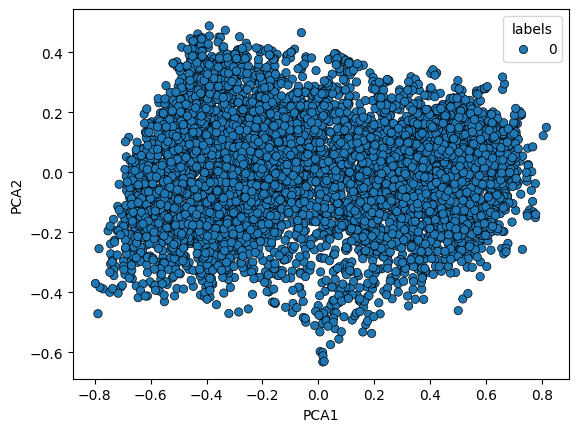

In [50]:
plot_dbscan(reduced_data)

Os clusters e identificação de anomalias acima não parecem estar tão bons, pois além de não identificarmos nenhuma anomalia, também temos apenas um cluster.

Pensando em encontrar o valor ideal de `eps`, utilizamos o `NearestNeighbors` para gerar um gráfico de linha e buscar o valor ideal nos baseando na **regra do cotovelo**.

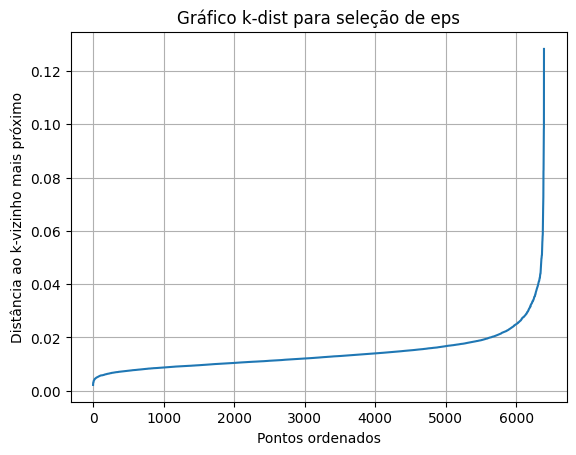

In [51]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(reduced_data)
distances, indices = neighbors_fit.kneighbors(reduced_data)
distances = np.sort(distances[:, k - 1])

plt.plot(distances)
plt.title("Gráfico k-dist para seleção de eps")
plt.xlabel("Pontos ordenados")
plt.ylabel("Distância ao k-vizinho mais próximo")
plt.grid(True)
plt.show()


O valor ficou na faixa de 0.01 ~ 0.02, tentaremos usar os dois

Anomalias detectadas: 117
Exemplo de anomalias:


,AT,EV,AP,RH,PE,Cluster
1,5.76,40.07,1013.22,62.99,494.67,-1
84,19.92,38.52,1018.15,60.68,451.16,-1
174,24.09,73.68,1014.93,94.55,441.34,-1
406,30.13,68.94,1005.88,40.71,441.78,-1
482,12.76,40.27,1006.58,49.34,474.03,-1


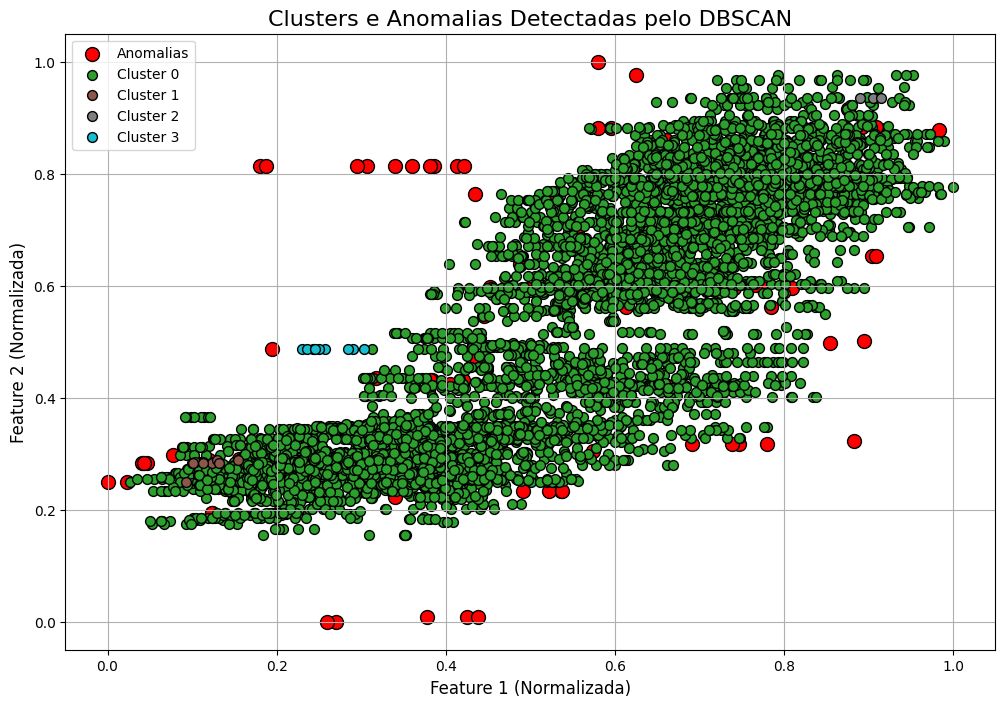

In [ ]:
dbscan = DBSCAN(eps=0.01)
dbscan.fit(scaled_energy_train_data)

energy_train_data['Cluster'] = dbscan.labels_
anomalies = energy_train_data[energy_train_data['Cluster'] == -1]

print(f"Anomalias detectadas: {len(anomalies)}")
if len(anomalies) > 0:
    print("Exemplo de anomalias:")
    display(anomalies.head())

fig, ax = plt.subplots(figsize=(12, 8))
clusters = dbscan.labels_
unique_clusters = np.unique(clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    cluster_data = scaled_energy_train_data[clusters == cluster]
    if cluster == -1:  # Anomalias
        ax.scatter(
            cluster_data[:, 0], 
            cluster_data[:, 1], 
            color='red', 
            edgecolor='k', 
            s=100, 
            label='Anomalias'
        )
    else:  # Clusters normais
        ax.scatter(
            cluster_data[:, 0], 
            cluster_data[:, 1], 
            color=color,
            edgecolor='k', 
            s=50, 
            label=f'Cluster {cluster}'
        )

# Melhorias no gráfico
ax.set_title("Clusters e Anomalias Detectadas pelo DBSCAN", fontsize=16)
ax.set_xlabel("Feature 1 (Normalizada)", fontsize=12)
ax.set_ylabel("Feature 2 (Normalizada)", fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True)
plt.show()